# Technical Analysis Fundamentals

Welcome to Module 2 of our Quantitative Trading course! In this notebook, we'll explore the foundations of technical analysis and learn to implement key indicators that form the backbone of many trading strategies.

## What You'll Learn:
1. **Technical Analysis Principles**: Understanding price action and market psychology
2. **Trend Analysis**: Identifying and measuring market trends
3. **Support and Resistance**: Key price levels that matter
4. **Moving Averages**: The foundation of trend-following systems
5. **Signal Generation**: Converting indicators into actionable trading signals
6. **Strategy Backtesting**: Testing our technical analysis approach

Let's dive into the world of technical analysis! 📊

## 1. Import Required Libraries

Let's start by importing all the libraries we'll need for technical analysis.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
import yfinance as yf
import requests
import os

# Visualization
import matplotlib.pyplot as plt

# Technical analysis libraries
from scipy import stats
from scipy.signal import find_peaks

# Set up plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Data Acquisition with Proxy Support

Let's create a robust data acquisition function that handles proxy settings for users who need them.

In [13]:
class DataManager:
    """A comprehensive data manager for financial data acquisition and processing."""
    
    def __init__(self, use_proxy=True, proxy_host="localhost", proxy_port=10809):
        self.use_proxy = use_proxy
        self.proxy_host = proxy_host
        self.proxy_port = proxy_port
        self.session = None
        self._setup_session()
    
    def _setup_session(self):
        """Set up requests session with proxy if needed."""
        self.session = requests.Session()
        if self.use_proxy:
            proxy_url = f"http://{self.proxy_host}:{self.proxy_port}"
            self.session.proxies.update({
                'http': proxy_url,
                'https': proxy_url
            })
            # Set environment variables for yfinance
            os.environ['HTTP_PROXY'] = proxy_url
            os.environ['HTTPS_PROXY'] = proxy_url
            print(f"🌐 Proxy configured: {proxy_url}")
    
    def get_stock_data(self, symbol, start_date, end_date=None, period="1d"):
        """Download stock data with comprehensive error handling."""
        if end_date is None:
            end_date = datetime.now().strftime("%Y-%m-%d")
        
        try:
            print(f"📈 Downloading {symbol} data from {start_date} to {end_date}")
            
            ticker = yf.Ticker(symbol)
            if self.use_proxy:
                ticker.session = self.session
            
            data = ticker.history(start=start_date, end=end_date, interval=period)
            
            if data.empty:
                raise ValueError(f"No data found for symbol {symbol}")
            
            # Clean up data
            data = data.dropna()
            data.index = pd.to_datetime(data.index)
            
            print(f"✅ Successfully downloaded {len(data)} trading days")
            print(f"📅 Date range: {data.index[0].date()} to {data.index[-1].date()}")
            print(f"💰 Latest close: ${data['Close'].iloc[-1]:.2f}")
            
            return data
            
        except Exception as e:
            print(f"❌ Error downloading data for {symbol}: {str(e)}")
            return None
    
    def get_multiple_stocks(self, symbols, start_date, end_date=None):
        """Download data for multiple stocks."""
        data_dict = {}
        for symbol in symbols:
            data = self.get_stock_data(symbol, start_date, end_date)
            if data is not None:
                data_dict[symbol] = data
        return data_dict

# Initialize data manager
dm = DataManager(use_proxy=True)  # Set to False if you don't need proxy

# Download sample data
symbol = "PLTR"
start_date = "2024-01-01"
data = dm.get_stock_data(symbol, start_date)

if data is not None:
    print(f"\n📊 Data shape: {data.shape}")
    print(f"\n🔍 Data preview:")
    display(data.head())

🌐 Proxy configured: http://localhost:10809
📈 Downloading PLTR data from 2024-01-01 to 2025-07-12
✅ Successfully downloaded 382 trading days
📅 Date range: 2024-01-02 to 2025-07-11
💰 Latest close: $142.10

📊 Data shape: (382, 7)

🔍 Data preview:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00-05:00,16.950001,16.950001,16.500000,16.58,41626700,0.0,0.0
2024-01-03 00:00:00-05:00,16.120001,16.379999,16.010000,16.09,46865200,0.0,0.0
2024-01-04 00:00:00-05:00,16.049999,16.580000,15.950000,16.25,39937700,0.0,0.0
2024-01-05 00:00:00-05:00,15.700000,16.128000,15.664000,15.98,57628800,0.0,0.0
2024-01-08 00:00:00-05:00,16.219999,16.889999,16.139999,16.67,49090000,0.0,0.0


## 3. Technical Analysis Foundation Class

Let's create a comprehensive class that implements various technical indicators from scratch.

In [14]:
class TechnicalAnalysis:
    """A comprehensive technical analysis toolkit."""
    
    def __init__(self, data):
        """Initialize with OHLCV data."""
        self.data = data.copy()
        self.close = data['Close']
        self.high = data['High']
        self.low = data['Low']
        self.open = data['Open']
        self.volume = data['Volume']
        
    def sma(self, period, price_col='Close'):
        """Simple Moving Average."""
        return self.data[price_col].rolling(window=period).mean()
    
    def ema(self, period, price_col='Close'):
        """Exponential Moving Average."""
        return self.data[price_col].ewm(span=period).mean()
    
    def rsi(self, period=14, price_col='Close'):
        """Relative Strength Index."""
        delta = self.data[price_col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def macd(self, fast=12, slow=26, signal=9, price_col='Close'):
        """MACD (Moving Average Convergence Divergence)."""
        ema_fast = self.ema(fast, price_col)
        ema_slow = self.ema(slow, price_col)
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal).mean()
        histogram = macd_line - signal_line
        
        return pd.DataFrame({
            'MACD': macd_line,
            'Signal': signal_line,
            'Histogram': histogram
        })
    
    def bollinger_bands(self, period=20, std_dev=2, price_col='Close'):
        """Bollinger Bands."""
        sma = self.sma(period, price_col)
        std = self.data[price_col].rolling(window=period).std()
        
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        
        return pd.DataFrame({
            'Middle': sma,
            'Upper': upper_band,
            'Lower': lower_band,
            'Width': upper_band - lower_band,
            'Position': (self.data[price_col] - lower_band) / (upper_band - lower_band)
        })
    
    def atr(self, period=14):
        """Average True Range."""
        high_low = self.high - self.low
        high_close = np.abs(self.high - self.close.shift())
        low_close = np.abs(self.low - self.close.shift())
        
        true_range = np.maximum(high_low, np.maximum(high_close, low_close))
        atr = true_range.rolling(window=period).mean()
        
        return atr
    
    def stochastic(self, k_period=14, d_period=3):
        """Stochastic Oscillator."""
        lowest_low = self.low.rolling(window=k_period).min()
        highest_high = self.high.rolling(window=k_period).max()
        
        k_percent = 100 * (self.close - lowest_low) / (highest_high - lowest_low)
        d_percent = k_percent.rolling(window=d_period).mean()
        
        return pd.DataFrame({
            'K': k_percent,
            'D': d_percent
        })
    
    def support_resistance(self, window=20, min_touches=2):
        """Identify support and resistance levels."""
        # Find local maxima and minima
        highs = find_peaks(self.high, distance=window)[0]
        lows = find_peaks(-self.low, distance=window)[0]
        
        # Get resistance levels (peaks)
        resistance_levels = self.high.iloc[highs]
        
        # Get support levels (troughs)
        support_levels = self.low.iloc[lows]
        
        return {
            'resistance': resistance_levels,
            'support': support_levels,
            'resistance_dates': self.data.index[highs],
            'support_dates': self.data.index[lows]
        }
    
    def trend_strength(self, period=20):
        """Calculate trend strength using linear regression."""
        trends = []
        r_squares = []
        
        for i in range(period, len(self.close)):
            y = self.close.iloc[i-period:i].values
            x = np.arange(len(y))
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            trends.append(slope)
            r_squares.append(r_value**2)
        
        trend_series = pd.Series([np.nan]*period + trends, index=self.data.index)
        r_square_series = pd.Series([np.nan]*period + r_squares, index=self.data.index)
        
        return pd.DataFrame({
            'Trend': trend_series,
            'Strength': r_square_series
        })

# Initialize technical analysis
if data is not None:
    ta = TechnicalAnalysis(data)
    print("✅ Technical Analysis toolkit initialized!")
    
    # Calculate some basic indicators
    data['SMA_20'] = ta.sma(20)
    data['EMA_20'] = ta.ema(20)
    data['RSI'] = ta.rsi(14)
    
    print("\n📊 Sample indicators calculated:")
    print(f"Latest SMA(20): ${data['SMA_20'].iloc[-1]:.2f}")
    print(f"Latest EMA(20): ${data['EMA_20'].iloc[-1]:.2f}")
    print(f"Latest RSI(14): {data['RSI'].iloc[-1]:.2f}")

✅ Technical Analysis toolkit initialized!

📊 Sample indicators calculated:
Latest SMA(20): $138.53
Latest EMA(20): $137.21
Latest RSI(14): 55.24


## 4. Advanced Visualization Functions

Let's create comprehensive visualization functions for technical analysis.

In [15]:
class TechnicalCharts:
    """Advanced charting for technical analysis."""
    
    def __init__(self, data, ta_instance):
        self.data = data
        self.ta = ta_instance
    
    def plot_price_with_ma(self, ma_periods=[20, 50], figsize=(15, 10)):
        """Plot price with moving averages."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
        
        # Price and moving averages
        ax1.plot(self.data.index, self.data['Close'], label='Close Price', linewidth=2, color='black')
        
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        for i, period in enumerate(ma_periods):
            sma = self.ta.sma(period)
            ema = self.ta.ema(period)
            
            ax1.plot(self.data.index, sma, label=f'SMA({period})', 
                    color=colors[i % len(colors)], alpha=0.7)
            ax1.plot(self.data.index, ema, label=f'EMA({period})', 
                    color=colors[i % len(colors)], alpha=0.7, linestyle='--')
        
        ax1.set_title(f'{self.data.index[0].strftime("%Y-%m-%d")} to {self.data.index[-1].strftime("%Y-%m-%d")} - Price with Moving Averages', fontsize=16)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Volume
        ax2.bar(self.data.index, self.data['Volume'], alpha=0.7, color='gray')
        ax2.set_ylabel('Volume', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_bollinger_bands(self, period=20, std_dev=2, figsize=(15, 12)):
        """Plot Bollinger Bands with price."""
        bb = self.ta.bollinger_bands(period, std_dev)
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, height_ratios=[3, 1, 1])
        
        # Price and Bollinger Bands
        ax1.plot(self.data.index, self.data['Close'], label='Close Price', color='black', linewidth=2)
        ax1.plot(self.data.index, bb['Upper'], label='Upper Band', color='red', alpha=0.7)
        ax1.plot(self.data.index, bb['Middle'], label='Middle Band (SMA)', color='blue', alpha=0.7)
        ax1.plot(self.data.index, bb['Lower'], label='Lower Band', color='green', alpha=0.7)
        
        # Fill between bands
        ax1.fill_between(self.data.index, bb['Upper'], bb['Lower'], alpha=0.1, color='gray')
        
        ax1.set_title(f'Bollinger Bands ({period}, {std_dev})', fontsize=16)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Band width
        ax2.plot(self.data.index, bb['Width'], label='Band Width', color='purple')
        ax2.set_ylabel('Band Width', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # %B (position within bands)
        ax3.plot(self.data.index, bb['Position'], label='%B Position', color='orange')
        ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax3.axhline(y=1, color='red', linestyle='--', alpha=0.5)
        ax3.axhline(y=0.5, color='blue', linestyle='--', alpha=0.5)
        ax3.set_ylabel('%B Position', fontsize=12)
        ax3.set_xlabel('Date', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_rsi_analysis(self, period=14, figsize=(15, 10)):
        """Plot RSI with overbought/oversold levels."""
        rsi = self.ta.rsi(period)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1])
        
        # Price
        ax1.plot(self.data.index, self.data['Close'], label='Close Price', color='black', linewidth=2)
        ax1.set_title(f'Price and RSI({period}) Analysis', fontsize=16)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # RSI
        ax2.plot(self.data.index, rsi, label=f'RSI({period})', color='purple', linewidth=2)
        ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
        ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
        ax2.axhline(y=50, color='blue', linestyle='-', alpha=0.5, label='Midline (50)')
        
        # Highlight overbought/oversold areas
        ax2.fill_between(self.data.index, 70, 100, alpha=0.2, color='red')
        ax2.fill_between(self.data.index, 0, 30, alpha=0.2, color='green')
        
        ax2.set_ylabel('RSI', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylim(0, 100)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_macd_analysis(self, fast=12, slow=26, signal=9, figsize=(15, 10)):
        """Plot MACD analysis."""
        macd_data = self.ta.macd(fast, slow, signal)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1])
        
        # Price
        ax1.plot(self.data.index, self.data['Close'], label='Close Price', color='black', linewidth=2)
        ax1.set_title(f'Price and MACD({fast},{slow},{signal}) Analysis', fontsize=16)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # MACD
        ax2.plot(self.data.index, macd_data['MACD'], label='MACD', color='blue', linewidth=2)
        ax2.plot(self.data.index, macd_data['Signal'], label='Signal', color='red', linewidth=2)
        
        # Histogram
        colors = ['green' if x > 0 else 'red' for x in macd_data['Histogram']]
        ax2.bar(self.data.index, macd_data['Histogram'], label='Histogram', 
                color=colors, alpha=0.6, width=1)
        
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.set_ylabel('MACD', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Initialize charts
if data is not None:
    charts = TechnicalCharts(data, ta)
    print("✅ Technical charting toolkit initialized!")

✅ Technical charting toolkit initialized!


## 5. Create Comprehensive Technical Analysis Dashboard

Let's visualize our indicators and understand what they're telling us about the market.

### 5.1 Moving Averages Theory

**Moving Averages** are fundamental trend-following indicators that smooth out price data to identify the direction of the trend.

#### Key Concepts:

**Simple Moving Average (SMA):**
- Calculates the arithmetic mean of prices over a specific period
- Formula: SMA = (P₁ + P₂ + ... + Pₙ) / n
- Gives equal weight to all prices in the period
- More stable but slower to react to price changes

**Exponential Moving Average (EMA):**
- Gives more weight to recent prices
- Formula: EMA = (Price × 2/(n+1)) + (Previous EMA × (1 - 2/(n+1)))
- More responsive to recent price movements
- Better for catching trend changes early

#### Trading Signals:
1. **Trend Direction**: Price above MA = uptrend, below MA = downtrend
2. **Crossovers**: Fast MA crossing above slow MA = buy signal
3. **Support/Resistance**: MAs often act as dynamic support/resistance levels

#### Best Practices:
- Use multiple timeframes (20, 50, 200 days are popular)
- Combine with other indicators for confirmation
- Works best in trending markets, less effective in sideways markets

📊 1. Price with Moving Averages


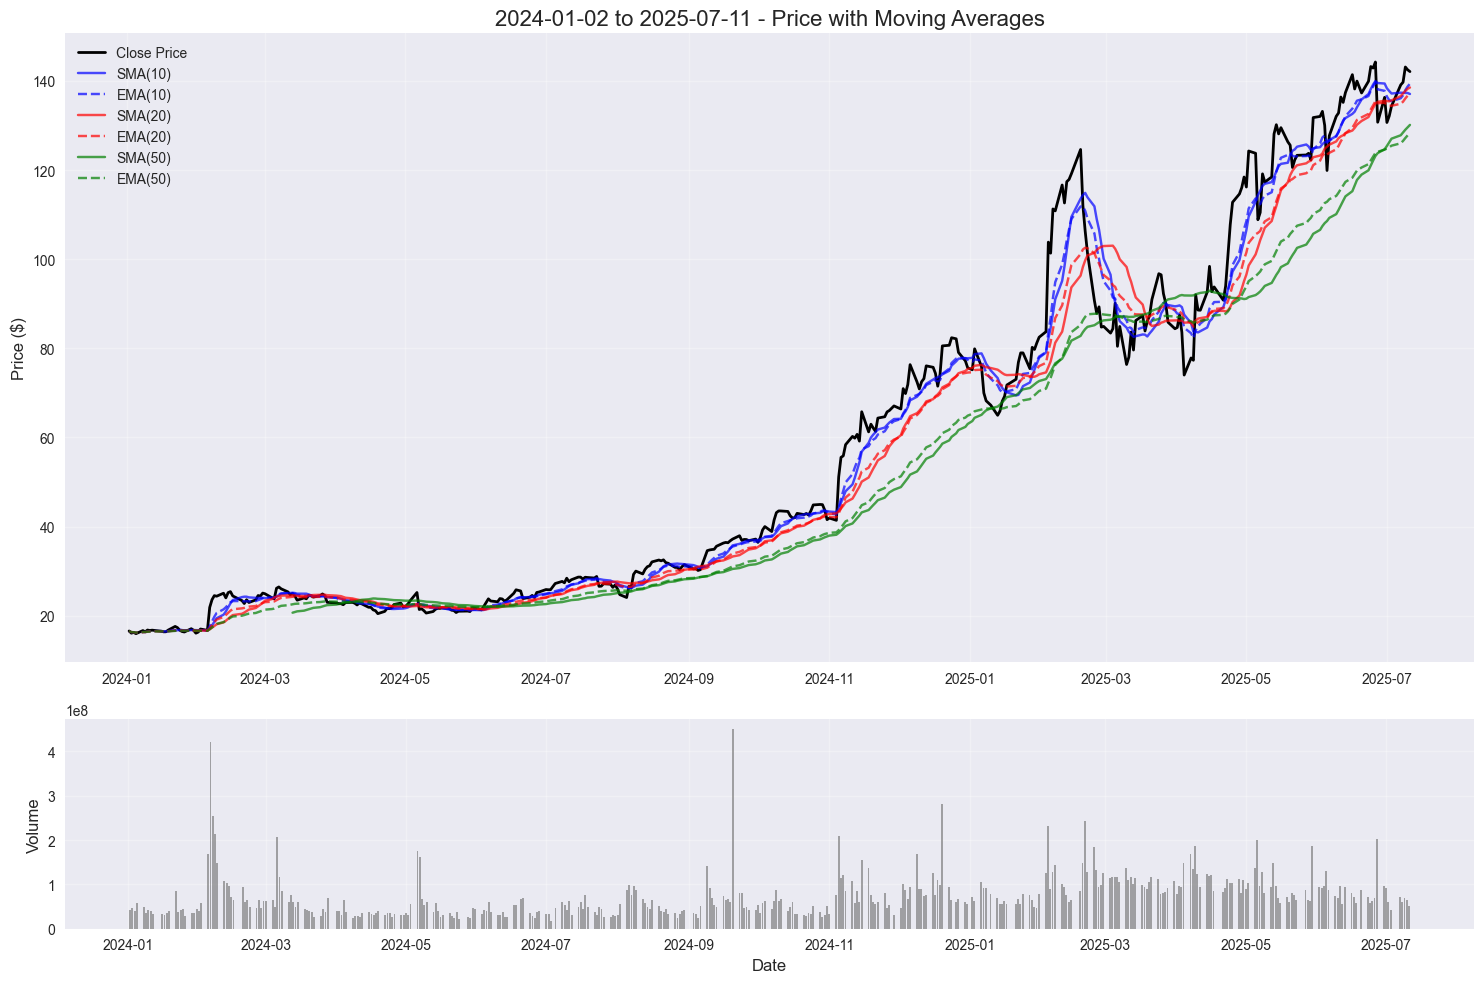

In [16]:
# Plot moving averages
print("📊 1. Price with Moving Averages")
charts.plot_price_with_ma([10, 20, 50])

### 5.2 Bollinger Bands Theory

**Bollinger Bands** consist of three lines that measure volatility and potential overbought/oversold conditions.

#### Components:
1. **Middle Band**: 20-period Simple Moving Average (SMA)
2. **Upper Band**: Middle Band + (2 × Standard Deviation)
3. **Lower Band**: Middle Band - (2 × Standard Deviation)

#### Key Concepts:

**Volatility Measurement:**
- Band width expands during high volatility periods
- Band width contracts during low volatility periods
- Volatility often follows periods of consolidation with breakouts

**Mean Reversion Signals:**
- Price touching upper band = potentially overbought
- Price touching lower band = potentially oversold
- Approximately 95% of price action occurs within the bands

**%B Indicator:**
- Measures where price is relative to the bands
- %B = (Price - Lower Band) / (Upper Band - Lower Band)
- Values above 1 = price above upper band
- Values below 0 = price below lower band

#### Trading Strategies:
1. **Squeeze**: Low volatility followed by expansion (breakout setup)
2. **Bounce**: Price bouncing off bands in trending markets
3. **Walk the Bands**: Strong trends where price stays near one band

#### Limitations:
- Works best in ranging markets for mean reversion
- In strong trends, price can "walk" along a band for extended periods
- False signals in choppy markets

📊 2. Bollinger Bands Analysis


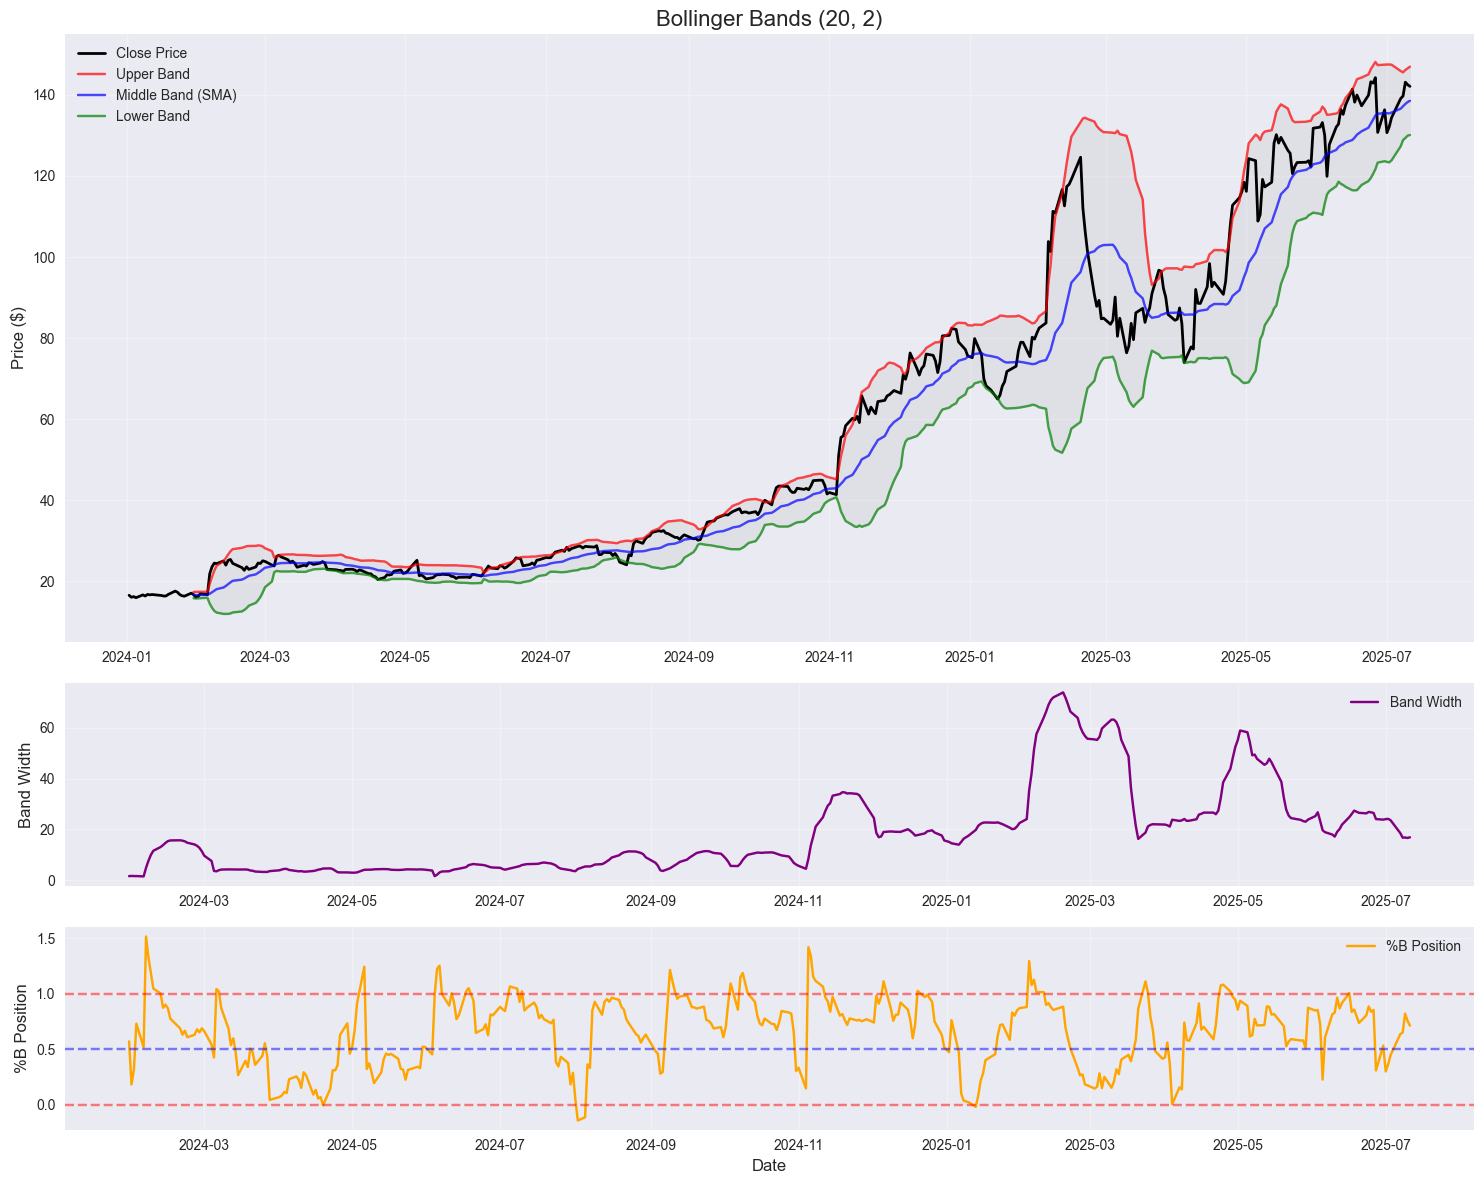

In [17]:
# Plot Bollinger Bands
print("📊 2. Bollinger Bands Analysis")
charts.plot_bollinger_bands()

### 5.3 RSI (Relative Strength Index) Theory

**RSI** is a momentum oscillator that measures the speed and change of price movements, ranging from 0 to 100.

#### Calculation:
- RSI = 100 - (100 / (1 + RS))
- RS (Relative Strength) = Average Gain / Average Loss
- Typically calculated over 14 periods

#### Key Levels:

**Overbought/Oversold:**
- RSI > 70: Generally considered overbought (potential sell signal)
- RSI < 30: Generally considered oversold (potential buy signal)
- RSI = 50: Neutral momentum

#### Advanced RSI Concepts:

**Divergences:**
- **Bullish Divergence**: Price makes lower lows, but RSI makes higher lows
- **Bearish Divergence**: Price makes higher highs, but RSI makes lower highs
- Divergences often signal potential trend reversals

**RSI Trendlines:**
- Draw trendlines on RSI just like on price charts
- RSI trendline breaks often precede price trendline breaks

**Failure Swings:**
- **Bullish Failure**: RSI dips below 30, rallies above 30, pulls back (but stays above 30), then breaks above previous high
- **Bearish Failure**: RSI rises above 70, falls below 70, rallies (but stays below 70), then breaks below previous low

#### Market Context:
- In strong uptrends, RSI can remain overbought (>70) for extended periods
- In strong downtrends, RSI can remain oversold (<30) for extended periods
- Adjust overbought/oversold levels based on market conditions (80/20 in strong trends)

#### Best Practices:
- Use RSI divergences for early trend reversal warnings
- Combine with trend analysis - don't fight the main trend
- Consider multiple timeframes for confirmation

📊 3. RSI Analysis


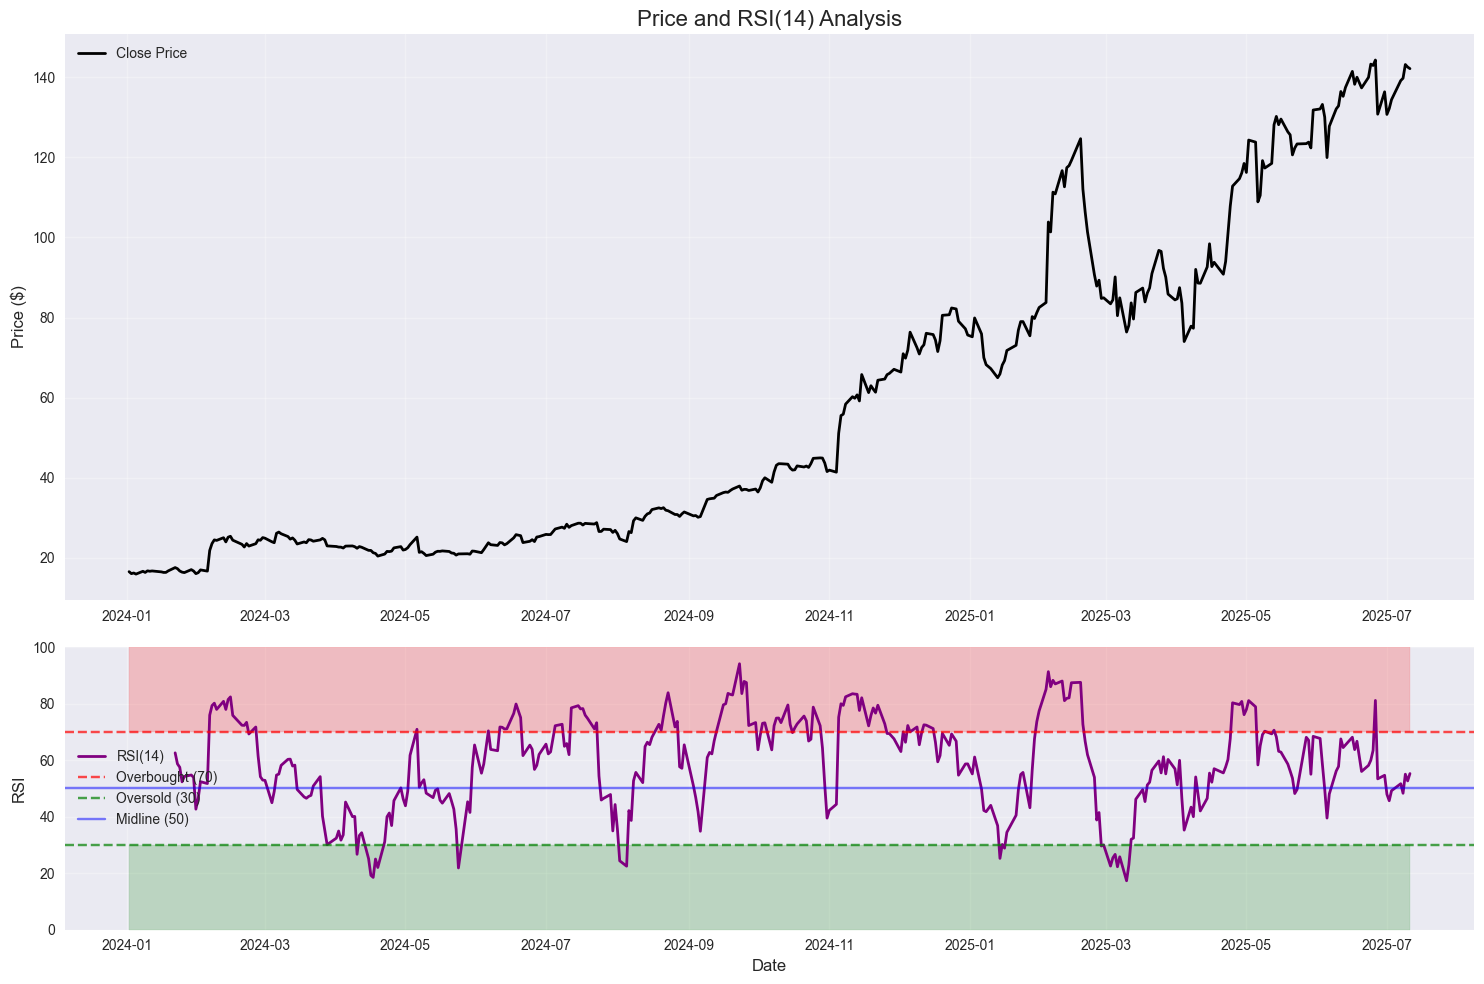

In [18]:
# Plot RSI
print("📊 3. RSI Analysis")
charts.plot_rsi_analysis()

### 5.4 MACD (Moving Average Convergence Divergence) Theory

**MACD** is both a trend-following and momentum indicator that shows the relationship between two moving averages.

#### Components:
1. **MACD Line**: 12-period EMA - 26-period EMA
2. **Signal Line**: 9-period EMA of the MACD line
3. **Histogram**: MACD Line - Signal Line

#### Key Concepts:

**Trend Analysis:**
- MACD above zero = short-term average above long-term average (bullish momentum)
- MACD below zero = short-term average below long-term average (bearish momentum)
- Rising MACD = momentum increasing
- Falling MACD = momentum decreasing

**Signal Generation:**

**1. Signal Line Crossovers:**
- MACD crosses above Signal Line = bullish signal (buy)
- MACD crosses below Signal Line = bearish signal (sell)
- Most common MACD trading signal

**2. Zero Line Crossovers:**
- MACD crosses above zero = trend confirmation (bullish)
- MACD crosses below zero = trend confirmation (bearish)
- Stronger signals but less frequent

**3. Histogram Analysis:**
- Histogram > 0: MACD above Signal Line (bullish momentum)
- Histogram < 0: MACD below Signal Line (bearish momentum)
- Histogram diverging from zero = momentum increasing
- Histogram converging to zero = momentum decreasing

#### Advanced MACD Concepts:

**Divergences:**
- **Bullish Divergence**: Price makes lower lows, MACD makes higher lows
- **Bearish Divergence**: Price makes higher highs, MACD makes lower highs
- Often precede trend reversals

**MACD Strategy Types:**
1. **Aggressive**: Trade all signal line crossovers
2. **Conservative**: Only trade crossovers in direction of main trend
3. **Confirmation**: Use MACD to confirm signals from other indicators

#### Limitations:
- Lagging indicator (based on moving averages)
- Can generate false signals in sideways markets
- Works best in trending markets
- May miss very fast price movements

📊 4. MACD Analysis


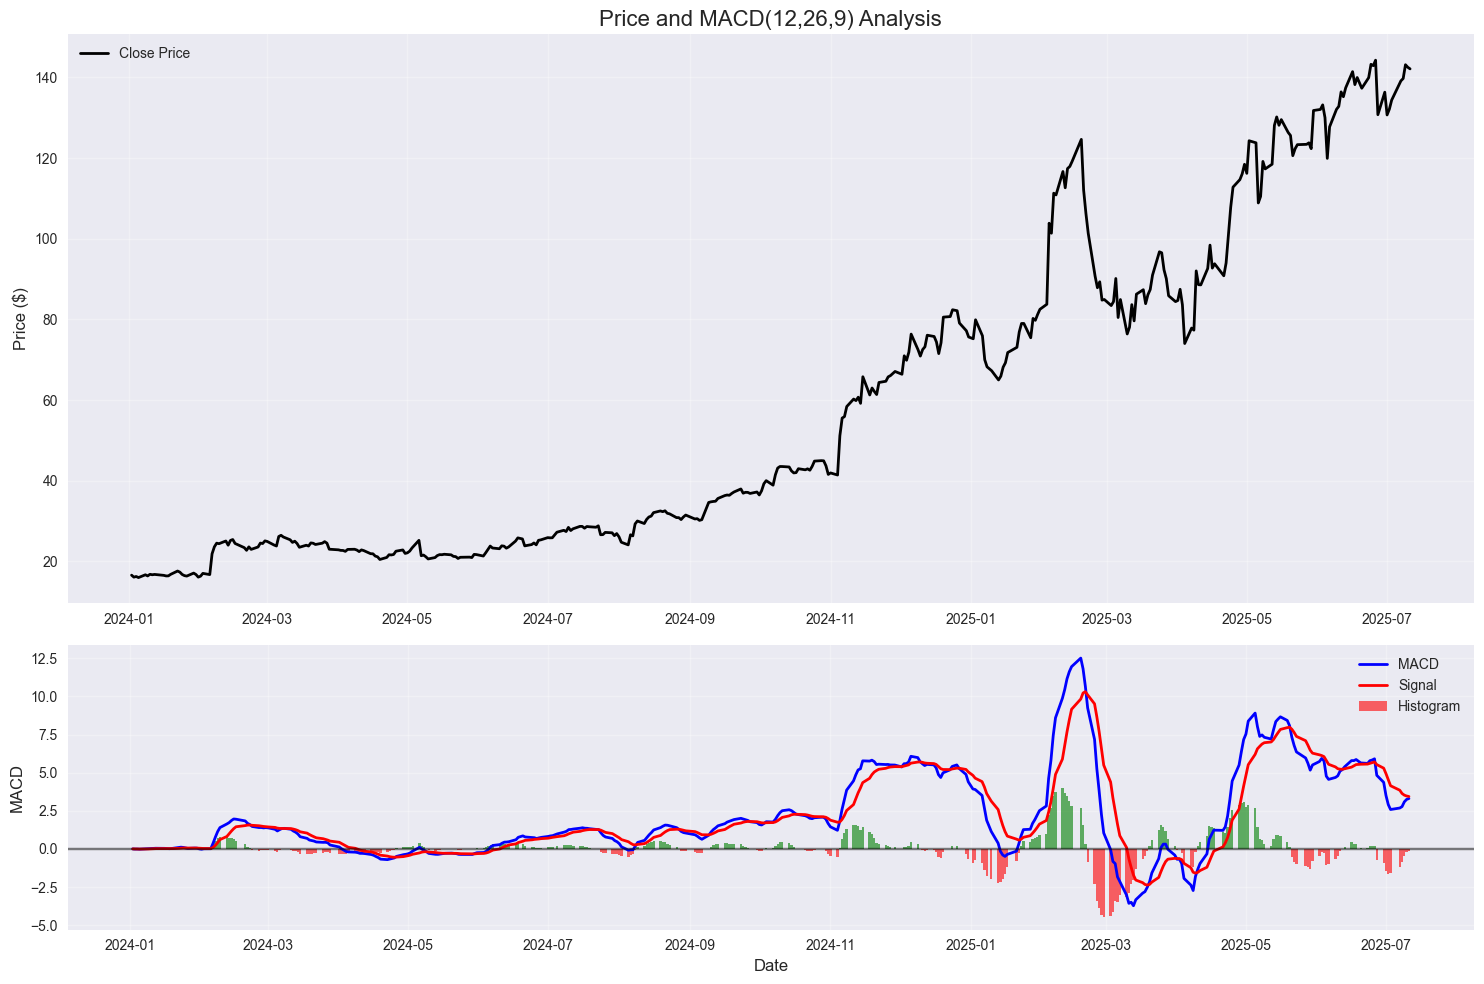

In [19]:
# Plot MACD
print("📊 4. MACD Analysis")
charts.plot_macd_analysis()

### 5.5 Combining Indicators - Multi-Indicator Analysis

**Successful technical analysis** often involves combining multiple indicators to create a more robust trading system.

#### Why Combine Indicators?

**1. Confirmation:** Multiple indicators agreeing increases confidence
**2. Filtering:** Reduce false signals by requiring multiple confirmations
**3. Different Perspectives:** Each indicator captures different market aspects
**4. Risk Management:** Diversify signal sources to reduce single-indicator risk

#### Indicator Categories:

**Trend Indicators:**
- Moving Averages (SMA, EMA)
- Identify market direction and trend strength

**Momentum Indicators:**
- RSI, MACD
- Measure speed of price changes and potential reversals

**Volatility Indicators:**
- Bollinger Bands, ATR
- Assess market volatility and potential breakouts

#### Multi-Indicator Strategies:

**Strategy 1: Trend + Momentum Confirmation**
- Use Moving Averages to identify trend direction
- Use RSI to time entries (buy on oversold in uptrend)
- Use MACD for trend change confirmation

**Strategy 2: Volatility Breakout**
- Use Bollinger Bands to identify low volatility periods
- Wait for price to break above/below bands
- Confirm with volume and momentum indicators

**Strategy 3: Divergence Analysis**
- Look for price/RSI divergences
- Confirm with MACD divergences
- Use Moving Averages for trend context

#### Signal Weighting System:

**Signal Strength Levels:**
- **Strong Buy (3 points):** All indicators bullish
- **Buy (2 points):** Majority of indicators bullish
- **Neutral (1 point):** Mixed signals
- **Sell (-2 points):** Majority of indicators bearish
- **Strong Sell (-3 points):** All indicators bearish

#### Common Pitfalls to Avoid:

1. **Over-optimization:** Too many indicators can lead to analysis paralysis
2. **Correlation:** Avoid redundant indicators that measure the same thing
3. **Lagging Nature:** Most indicators are based on past prices
4. **Market Conditions:** Indicators perform differently in trending vs. ranging markets

#### Best Practices:

1. **Start Simple:** Begin with 2-3 complementary indicators
2. **Understand Each Indicator:** Know strengths and weaknesses
3. **Market Context:** Consider overall market conditions
4. **Backtesting:** Test combinations on historical data
5. **Paper Trading:** Practice with virtual money before risking capital

Now let's see how these indicators perform on our actual data!

## 6. Signal Generation System

Now let's create a comprehensive signal generation system that combines multiple indicators.

In [20]:
class SignalGenerator:
    """Generate trading signals from technical indicators."""
    
    def __init__(self, data, ta_instance):
        self.data = data.copy()
        self.ta = ta_instance
        self.signals = pd.DataFrame(index=data.index)
    
    def moving_average_crossover(self, fast_period=20, slow_period=50):
        """Generate signals from moving average crossovers."""
        fast_ma = self.ta.sma(fast_period)
        slow_ma = self.ta.sma(slow_period)
        
        # Signal: 1 for buy, -1 for sell, 0 for hold
        signal = np.where(fast_ma > slow_ma, 1, -1)
        
        # Only signal on crossovers (changes)
        signal_diff = np.diff(signal, prepend=signal[0])
        crossover_signal = np.where(signal_diff != 0, signal, 0)
        
        self.signals[f'MA_Cross_{fast_period}_{slow_period}'] = crossover_signal
        return crossover_signal
    
    def rsi_signals(self, period=14, oversold=30, overbought=70):
        """Generate signals from RSI overbought/oversold levels."""
        rsi = self.ta.rsi(period)
        
        # Buy when RSI crosses above oversold, sell when crosses below overbought
        buy_signal = (rsi.shift(1) <= oversold) & (rsi > oversold)
        sell_signal = (rsi.shift(1) >= overbought) & (rsi < overbought)
        
        signal = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))
        
        self.signals[f'RSI_{period}'] = signal
        return signal
    
    def macd_signals(self, fast=12, slow=26, signal_period=9):
        """Generate signals from MACD crossovers."""
        macd_data = self.ta.macd(fast, slow, signal_period)
        
        # Signal when MACD crosses signal line
        macd_line = macd_data['MACD']
        signal_line = macd_data['Signal']
        
        buy_signal = (macd_line.shift(1) <= signal_line.shift(1)) & (macd_line > signal_line)
        sell_signal = (macd_line.shift(1) >= signal_line.shift(1)) & (macd_line < signal_line)
        
        signal = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))
        
        self.signals[f'MACD_{fast}_{slow}_{signal_period}'] = signal
        return signal
    
    def bollinger_signals(self, period=20, std_dev=2):
        """Generate signals from Bollinger Bands."""
        bb = self.ta.bollinger_bands(period, std_dev)
        
        # Buy when price touches lower band, sell when touches upper band
        buy_signal = self.data['Close'] <= bb['Lower']
        sell_signal = self.data['Close'] >= bb['Upper']
        
        signal = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))
        
        self.signals[f'BB_{period}_{std_dev}'] = signal
        return signal
    
    def composite_signal(self, weights=None):
        """Create a composite signal from all individual signals."""
        if weights is None:
            weights = {col: 1 for col in self.signals.columns}
        
        weighted_signals = pd.DataFrame(index=self.signals.index)
        
        for col in self.signals.columns:
            if col in weights:
                weighted_signals[col] = self.signals[col] * weights[col]
        
        # Sum all weighted signals
        composite = weighted_signals.sum(axis=1)
        
        # Normalize to -1, 0, 1
        composite_signal = np.where(composite > 0, 1, np.where(composite < 0, -1, 0))
        
        self.signals['Composite'] = composite_signal
        return composite_signal
    
    def generate_all_signals(self):
        """Generate all types of signals."""
        print("🔄 Generating trading signals...")
        
        # Generate individual signals
        self.moving_average_crossover(20, 50)
        self.rsi_signals(14, 30, 70)
        self.macd_signals(12, 26, 9)
        self.bollinger_signals(20, 2)
        
        # Create composite signal
        self.composite_signal()
        
        print("✅ All signals generated!")
        
        # Summary
        signal_summary = {}
        for col in self.signals.columns:
            buy_signals = (self.signals[col] == 1).sum()
            sell_signals = (self.signals[col] == -1).sum()
            signal_summary[col] = {'Buy': buy_signals, 'Sell': sell_signals}
        
        return signal_summary
    
    def plot_signals(self, figsize=(15, 12)):
        """Plot price with all generated signals."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
        
        # Price chart
        ax1.plot(self.data.index, self.data['Close'], label='Close Price', color='black', linewidth=2)
        
        # Plot buy/sell signals for composite signal
        buy_signals = self.signals['Composite'] == 1
        sell_signals = self.signals['Composite'] == -1
        
        ax1.scatter(self.data.index[buy_signals], self.data['Close'][buy_signals], 
                   color='green', marker='^', s=100, label='Buy Signal', zorder=5)
        ax1.scatter(self.data.index[sell_signals], self.data['Close'][sell_signals], 
                   color='red', marker='v', s=100, label='Sell Signal', zorder=5)
        
        ax1.set_title('Price with Trading Signals', fontsize=16)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Signal strength over time
        ax2.plot(self.data.index, self.signals['Composite'], label='Composite Signal', 
                color='purple', linewidth=2)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.fill_between(self.data.index, 0, self.signals['Composite'], 
                        where=(self.signals['Composite'] > 0), alpha=0.3, color='green')
        ax2.fill_between(self.data.index, 0, self.signals['Composite'], 
                        where=(self.signals['Composite'] < 0), alpha=0.3, color='red')
        
        ax2.set_ylabel('Signal Strength', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Generate signals
if data is not None:
    sg = SignalGenerator(data, ta)
    signal_summary = sg.generate_all_signals()
    
    print("\n📊 Signal Summary:")
    for signal_type, counts in signal_summary.items():
        print(f"{signal_type}: {counts['Buy']} Buy, {counts['Sell']} Sell")

🔄 Generating trading signals...
✅ All signals generated!

📊 Signal Summary:
MA_Cross_20_50: 3 Buy, 2 Sell
RSI_14: 7 Buy, 22 Sell
MACD_12_26_9: 17 Buy, 18 Sell
BB_20_2: 4 Buy, 42 Sell
Composite: 26 Buy, 76 Sell


📊 Trading Signals Visualization


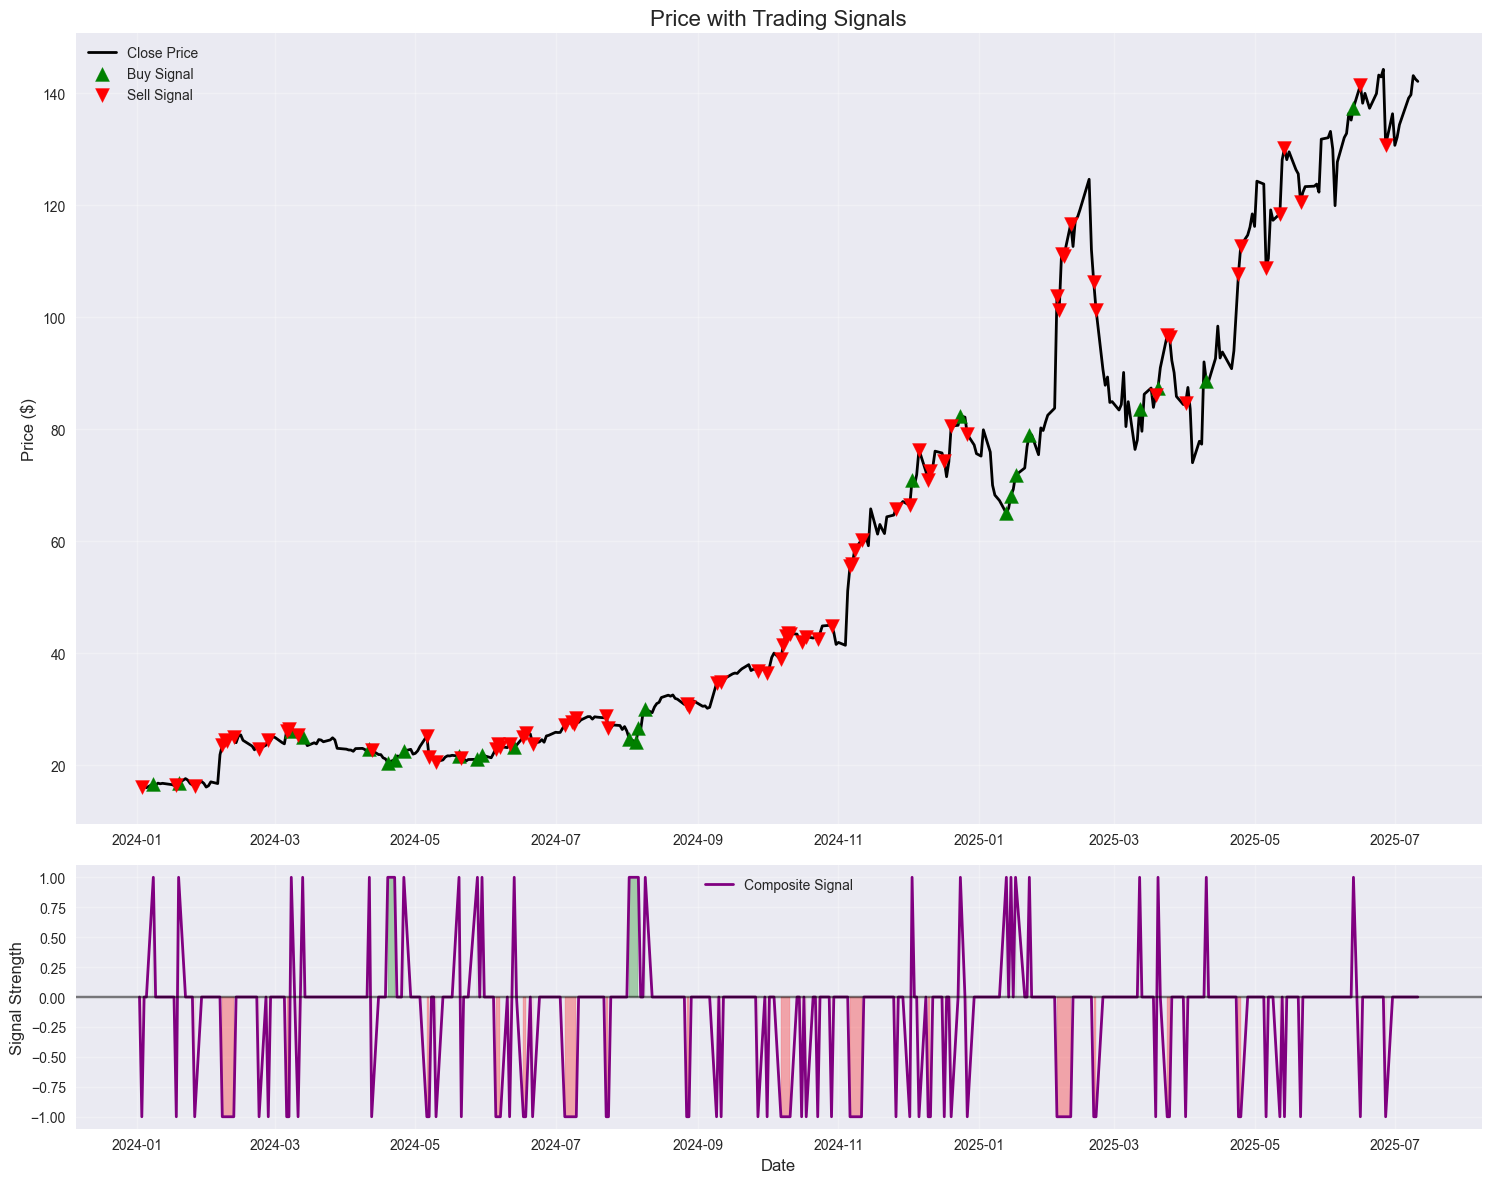

In [21]:
# Plot signals
print("📊 Trading Signals Visualization")
sg.plot_signals()

## 7. Simple Backtesting Framework

Let's create a basic backtesting framework to evaluate our technical analysis strategy.

In [22]:
class SimpleBacktester:
    """Simple backtesting framework for technical analysis strategies."""
    
    def __init__(self, data, signals, initial_capital=10000, commission=0.001):
        self.data = data.copy()
        self.signals = signals.copy()
        self.initial_capital = initial_capital
        self.commission = commission
        self.results = None
    
    def backtest(self, signal_column='Composite'):
        """Run backtest for specified signal column."""
        # Initialize tracking variables
        capital = self.initial_capital
        position = 0  # 0 = no position, 1 = long, -1 = short
        shares = 0
        
        # Track results
        portfolio_value = []
        cash = []
        holdings = []
        trades = []
        
        for i, (date, row) in enumerate(self.data.iterrows()):
            price = row['Close']
            signal = self.signals.loc[date, signal_column] if date in self.signals.index else 0
            
            # Execute trades based on signals
            if signal == 1 and position <= 0:  # Buy signal
                if position == -1:  # Close short position first
                    capital += shares * price * (1 - self.commission)
                    shares = 0
                
                # Open long position
                shares = capital / (price * (1 + self.commission))
                capital = 0
                position = 1
                trades.append({'Date': date, 'Action': 'BUY', 'Price': price, 'Shares': shares})
                
            elif signal == -1 and position >= 0:  # Sell signal
                if position == 1:  # Close long position
                    capital = shares * price * (1 - self.commission)
                    shares = 0
                    position = 0
                    trades.append({'Date': date, 'Action': 'SELL', 'Price': price, 'Shares': shares})
            
            # Calculate portfolio value
            if position == 1:  # Long position
                portfolio_val = shares * price
                cash_val = 0
            else:  # No position or short
                portfolio_val = capital
                cash_val = capital
            
            portfolio_value.append(portfolio_val)
            cash.append(cash_val)
            holdings.append(shares * price if position == 1 else 0)
        
        # Create results DataFrame
        self.results = pd.DataFrame({
            'Date': self.data.index,
            'Price': self.data['Close'],
            'Portfolio_Value': portfolio_value,
            'Cash': cash,
            'Holdings': holdings,
            'Signal': self.signals[signal_column] if signal_column in self.signals.columns else 0
        }).set_index('Date')
        
        # Calculate returns
        self.results['Strategy_Return'] = self.results['Portfolio_Value'].pct_change()
        self.results['Buy_Hold_Value'] = (self.initial_capital * 
                                         self.data['Close'] / self.data['Close'].iloc[0])
        self.results['Buy_Hold_Return'] = self.results['Buy_Hold_Value'].pct_change()
        
        # Store trades
        self.trades = pd.DataFrame(trades)
        
        return self.results
    
    def calculate_metrics(self):
        """Calculate performance metrics."""
        if self.results is None:
            return None
        
        # Basic metrics
        total_return_strategy = (self.results['Portfolio_Value'].iloc[-1] / self.initial_capital - 1) * 100
        total_return_buyhold = (self.results['Buy_Hold_Value'].iloc[-1] / self.initial_capital - 1) * 100
        
        # Annualized returns (assuming daily data)
        days = len(self.results)
        years = days / 252  # Trading days per year
        
        annualized_return_strategy = ((1 + total_return_strategy/100) ** (1/years) - 1) * 100
        annualized_return_buyhold = ((1 + total_return_buyhold/100) ** (1/years) - 1) * 100
        
        # Volatility (annualized)
        strategy_vol = self.results['Strategy_Return'].std() * np.sqrt(252) * 100
        buyhold_vol = self.results['Buy_Hold_Return'].std() * np.sqrt(252) * 100
        
        # Sharpe Ratio (assuming 0% risk-free rate)
        sharpe_strategy = annualized_return_strategy / strategy_vol if strategy_vol > 0 else 0
        sharpe_buyhold = annualized_return_buyhold / buyhold_vol if buyhold_vol > 0 else 0
        
        # Maximum drawdown
        rolling_max = self.results['Portfolio_Value'].expanding().max()
        drawdown = (self.results['Portfolio_Value'] - rolling_max) / rolling_max * 100
        max_drawdown_strategy = drawdown.min()
        
        rolling_max_bh = self.results['Buy_Hold_Value'].expanding().max()
        drawdown_bh = (self.results['Buy_Hold_Value'] - rolling_max_bh) / rolling_max_bh * 100
        max_drawdown_buyhold = drawdown_bh.min()
        
        # Number of trades
        num_trades = len(self.trades) if hasattr(self, 'trades') else 0
        
        metrics = {
            'Total Return - Strategy (%)': round(total_return_strategy, 2),
            'Total Return - Buy & Hold (%)': round(total_return_buyhold, 2),
            'Annualized Return - Strategy (%)': round(annualized_return_strategy, 2),
            'Annualized Return - Buy & Hold (%)': round(annualized_return_buyhold, 2),
            'Volatility - Strategy (%)': round(strategy_vol, 2),
            'Volatility - Buy & Hold (%)': round(buyhold_vol, 2),
            'Sharpe Ratio - Strategy': round(sharpe_strategy, 2),
            'Sharpe Ratio - Buy & Hold': round(sharpe_buyhold, 2),
            'Max Drawdown - Strategy (%)': round(max_drawdown_strategy, 2),
            'Max Drawdown - Buy & Hold (%)': round(max_drawdown_buyhold, 2),
            'Number of Trades': num_trades,
            'Final Portfolio Value ($)': round(self.results['Portfolio_Value'].iloc[-1], 2)
        }
        
        return metrics
    
    def plot_results(self, figsize=(15, 12)):
        """Plot backtest results."""
        if self.results is None:
            print("No results to plot. Run backtest first.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        
        # Portfolio value comparison
        ax1.plot(self.results.index, self.results['Portfolio_Value'], 
                label='Strategy', linewidth=2, color='blue')
        ax1.plot(self.results.index, self.results['Buy_Hold_Value'], 
                label='Buy & Hold', linewidth=2, color='gray')
        ax1.set_title('Portfolio Value Comparison', fontsize=14)
        ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Drawdown
        rolling_max = self.results['Portfolio_Value'].expanding().max()
        drawdown = (self.results['Portfolio_Value'] - rolling_max) / rolling_max * 100
        ax2.fill_between(self.results.index, drawdown, 0, alpha=0.7, color='red')
        ax2.set_title('Strategy Drawdown', fontsize=14)
        ax2.set_ylabel('Drawdown (%)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Cumulative returns
        strategy_cumret = (1 + self.results['Strategy_Return']).cumprod() - 1
        buyhold_cumret = (1 + self.results['Buy_Hold_Return']).cumprod() - 1
        
        ax3.plot(self.results.index, strategy_cumret * 100, 
                label='Strategy', linewidth=2, color='blue')
        ax3.plot(self.results.index, buyhold_cumret * 100, 
                label='Buy & Hold', linewidth=2, color='gray')
        ax3.set_title('Cumulative Returns', fontsize=14)
        ax3.set_ylabel('Cumulative Return (%)', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Rolling Sharpe ratio (30-day window)
        rolling_sharpe = (self.results['Strategy_Return'].rolling(30).mean() / 
                         self.results['Strategy_Return'].rolling(30).std() * np.sqrt(252))
        ax4.plot(self.results.index, rolling_sharpe, linewidth=2, color='purple')
        ax4.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Good (>1)')
        ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Poor (<0)')
        ax4.set_title('Rolling Sharpe Ratio (30-day)', fontsize=14)
        ax4.set_ylabel('Sharpe Ratio', fontsize=12)
        ax4.set_xlabel('Date', fontsize=12)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Run backtest
if data is not None and 'sg' in locals():
    print("🔄 Running backtest...")
    backtester = SimpleBacktester(data, sg.signals, initial_capital=10000)
    results = backtester.backtest('Composite')
    metrics = backtester.calculate_metrics()
    
    print("\n📈 Backtest Results:")
    print("=" * 50)
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    if hasattr(backtester, 'trades') and len(backtester.trades) > 0:
        print(f"\n📊 Recent Trades:")
        display(backtester.trades.tail())

🔄 Running backtest...

📈 Backtest Results:
Total Return - Strategy (%): 241.32
Total Return - Buy & Hold (%): 757.06
Annualized Return - Strategy (%): 124.76
Annualized Return - Buy & Hold (%): 312.57
Volatility - Strategy (%): 34.36
Volatility - Buy & Hold (%): 70.54
Sharpe Ratio - Strategy: 3.63
Sharpe Ratio - Buy & Hold: 4.43
Max Drawdown - Strategy (%): -19.22
Max Drawdown - Buy & Hold (%): -40.61
Number of Trades: 32
Final Portfolio Value ($): 34132.19

📊 Recent Trades:


,Date,Action,Price,Shares
27,2025-03-24 00:00:00-04:00,SELL,96.750000,0.000000
28,2025-04-10 00:00:00-04:00,BUY,88.589996,308.628256
29,2025-04-24 00:00:00-04:00,SELL,107.779999,0.000000
30,2025-06-13 00:00:00-04:00,BUY,137.399994,241.612031
31,2025-06-16 00:00:00-04:00,SELL,141.410004,0.000000


📊 Backtest Performance Visualization


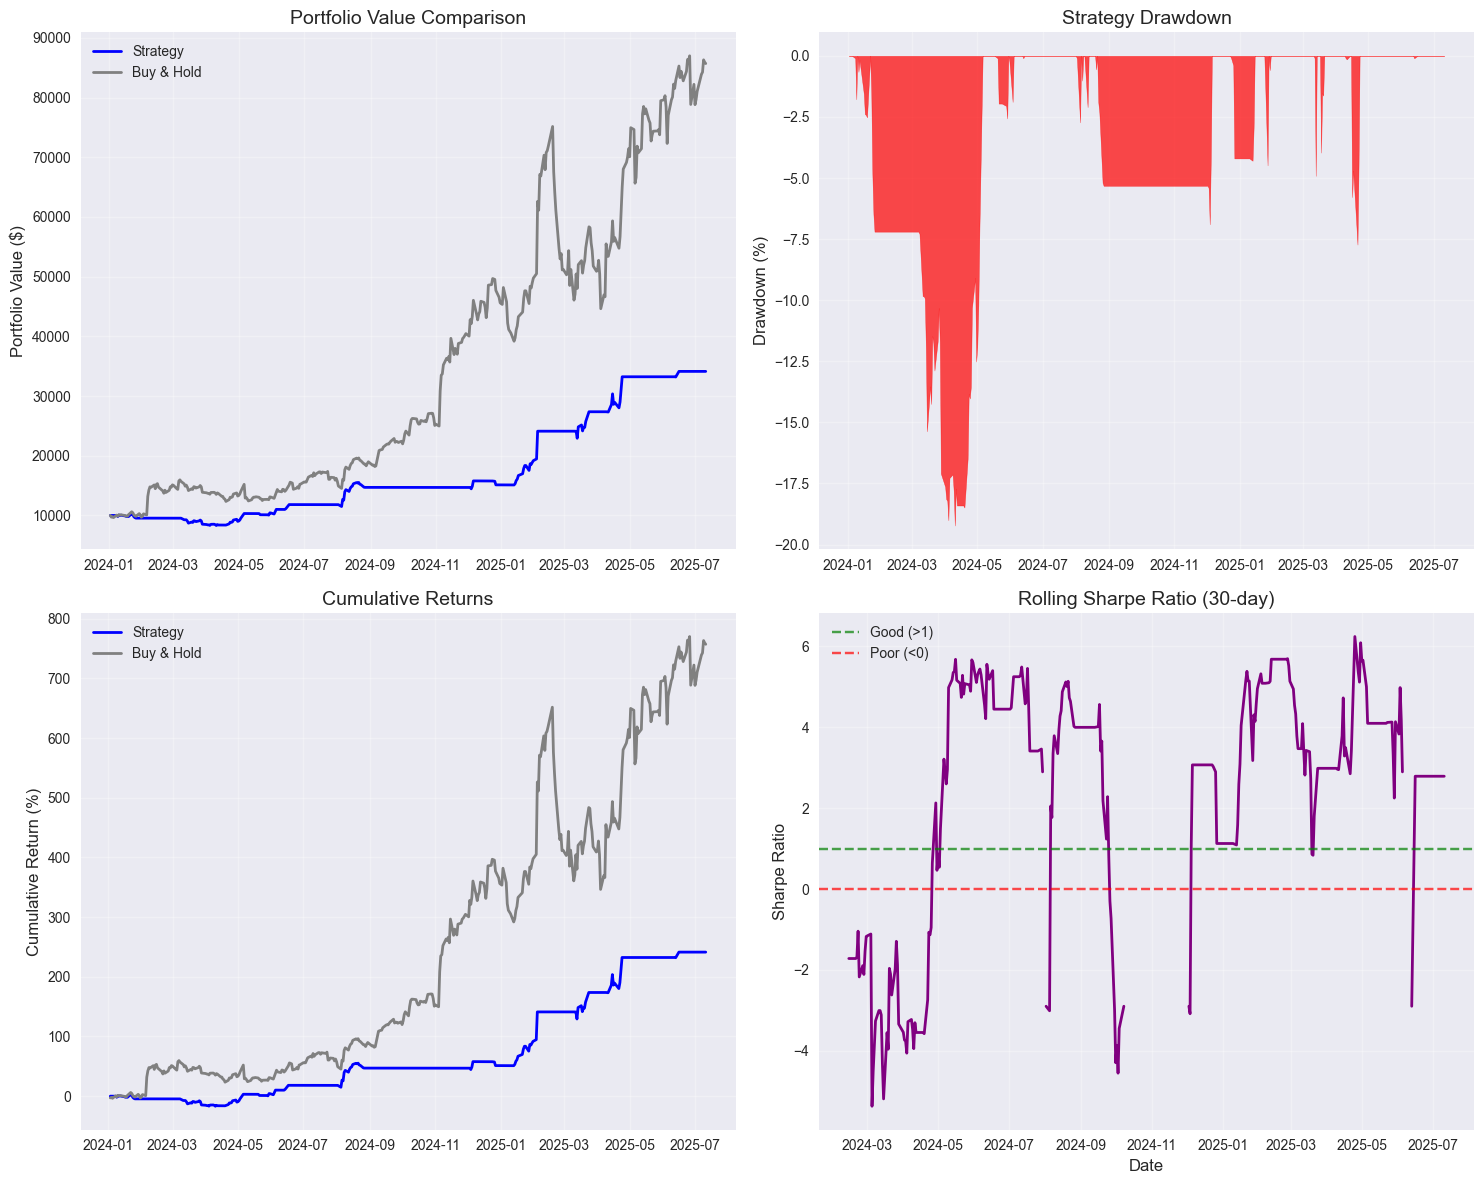

In [23]:
# Plot backtest results
print("📊 Backtest Performance Visualization")
backtester.plot_results()

## 8. Summary and Key Takeaways

### What We've Learned:

1. **Technical Analysis Fundamentals**
   - Moving averages (SMA, EMA) for trend identification
   - RSI for momentum and overbought/oversold conditions
   - MACD for trend changes and momentum
   - Bollinger Bands for volatility and mean reversion

2. **Signal Generation**
   - Individual indicator signals
   - Composite signal creation
   - Signal filtering and confirmation

3. **Backtesting Framework**
   - Strategy performance evaluation
   - Risk metrics calculation
   - Comparison with buy-and-hold

### Key Insights:

- **No Single Indicator is Perfect**: Combining multiple indicators often provides better signals
- **Context Matters**: Market conditions affect indicator effectiveness
- **Risk Management is Crucial**: Drawdown control is as important as returns
- **Transaction Costs Matter**: Real-world trading includes commissions and slippage

### Next Steps:

1. **Experiment with Parameters**: Try different period lengths and thresholds
2. **Add More Indicators**: Volume-based indicators, volatility measures
3. **Improve Signal Filtering**: Add confirmation requirements
4. **Risk Management**: Position sizing, stop losses, profit targets
5. **Market Regime Detection**: Adapt strategies to different market conditions

### Practice Exercises:

1. **Modify Parameters**: Change RSI periods, MA lengths, and observe impact
2. **Add New Indicators**: Implement Stochastic, Williams %R, or CCI
3. **Create Custom Signals**: Combine indicators in new ways
4. **Test Different Assets**: Apply to different stocks, ETFs, or forex
5. **Improve Backtesting**: Add transaction costs, slippage, position sizing

Remember: **Past performance does not guarantee future results!** Always validate strategies on out-of-sample data and consider real-world trading constraints.